In [10]:
#Charger le repertoire des scripts
import sys
import os
sys.path.append(os.path.abspath('./Library'))
import numpy as np
from matplotlib.pyplot import close, show
import matplotlib.pyplot as plt
import xarray as xr
from reef_models import reef_platform, reef, reef_eros
from tools import nlines, readfile
from tools_models import CheckSimu, ZarrName, shore
from Profile import Profile
from Dicts import Dicos
from datetime import datetime as dtime
from os import path
import xsimlab as xs
from Dict_models import DicoModels
from scipy.interpolate import interp1d


## Model setup

You only have to run the following cell, do not modify

In [11]:
class REEF:
    
    def __init__(self):
        # Define the fixed parameters
        self.input_vars = {
            # Water height for open ocean
            'hfactor__how': 2,
            # uniform spacing
            'grid__spacing': 1,
            # Grid width factor. Should be similar to hmax 
            'grid__dmax': 20,
            # Coefficient for erosion efficiency, sea-bed
            'eros__beta1': 0.1,
            # Coefficient for erosion efficiency, cliff retreat
            'eros__beta2': 1,
            # Height of notch for volume eroded during cliff retreat
            'eros__hnotch': 1,
            # Repos angle
            'depot__repos': 15e-2,
        }
    
    def reef_params(self, SL, U, slop, Gm, Ev, hmax=20, Dbar=100, hwb=3.):
        # Complete the dictionnary of fixed parameters with the ones to test
        self.input_vars.update({
            ## Usefull parameters to test. Everything in meters and years.
            # filename for RSL reconstruction
            'SLstory__RSLin': SL,
            # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
            'vertical__u': U,
            # initial slope of the substrate. [2 - 8]
            'grid__slopi': slop,
            # maximum reef growth rate. [2 - 15]
            'construct__Gm': Gm,            
            # Eroded volume. [50 - 1000]e-3
            'eros__Ev': Ev,
            # maximum water height for reef growth. [10 - 50] 
            'construct__hmax': hmax,
            # width of wave action (controls the width of the coral reef). [10 - 3000] 
            'hfactor__Dbar': Dbar,
            # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
            'eros__hwb': float(hwb),
        })
        
    def run(self, dt, save):
        self.save = save
        dico = Dicos()
        # Define the output of the model
        if save==True:
            output = {
                'init__x'       : None,
                'profile__z'    : 'time',
                'sealevel__asl' : 'time',
                'profile__xmin' : None,
                'profile__xmax' : None,
                'depot__dS'     : 'time',
                'construct__dG' : 'time',
            }
        elif save==False:
            output={
                'init__x'       : None,
                'profile__z'    : None,
                'sealevel__asl' : None,
                'profile__xmin' : None,
                'profile__xmax' : None,
            }
        else:
            raise Exception("Wrong format for 'save' variable. Should be True or False")

        tmax = nlines(dico.path_SLcurves+self.input_vars['SLstory__RSLin'])*1e3
        print("Simu of", tmax/1000, "ky")
        # Create xsimlab setup
        ds_in = xs.create_setup(
            model=reef,
            clocks={'time' : np.arange(0., tmax+dt, dt)},
            master_clock = 'time',
            input_vars = self.input_vars,
            output_vars = output
        )
        ds_in.attrs['model_name'] = 'reef'
        ds_in.attrs['store'] = 'Profile'

        # Run the model
        t0=dtime.today()
        dm   = DicoModels()
        with dm.models[ds_in.model_name]:
            self.ds_out = (ds_in   
              .xsimlab.run()
                  )
        print('Duration', dtime.today()-t0)

    def plot(self, compare=False):
        if self.save==True:
            print('Starting plot')
            fig = Profile(self.ds_out)
            fig.ProfileName('.png')
            fig.PlotProfile()
            fig.PlotASL()
            fig.WriteParams()
            fig.Savefig()
            show()
            close('all')
        elif self.save==False:
            if compare==False:
                plt.plot(self.ds_out.profile__z)
            elif type(compare)==str:
                # Extracts x and y in the topo files
                self.x_obs, self.y_obs = readfile(
                    os.path.abspath('../Topo_obs/'+compare))
                self.align()
                plt.plot(self.x, self.y, label='modelled')
                plt.plot(self.x_obs, self.y_obs, label='observed')
                plt.legend()
            else:
                raise Exception("Wrong format for 'compare'. Must be string format for path")
        else:
            raise Exception("Wrong format for 'layers' variable. Should be True or False")

    def align(self):
        ipmin = min(self.x_obs)
        ipmax = max(self.x_obs)
        y_obs_min = min(self.y_obs)

        # Extract x and y from model output
        x = self.ds_out.profile__z.x.values
        y = self.ds_out.profile__z.values
        
        # Extract the index in y of the first element >= to the min value in y_obs.
        index_min = np.argmax(y >= y_obs_min) 
        # Use this index for the x starting value.
        x_start = x[index_min]
        
        ipmod = interp1d(x, y) # Interpolate y as a function of x.
        # Generate new continuous x values from x_start to max x value in topo_obs.
        # with the step defined in Inputs.inversion_params.
        self.x = np.arange(x_start, x_start - ipmin + ipmax, 1)
        self.y = ipmod(self.x) # Interpolation of the vertical values on new x_n axis.
        self.x = self.x - self.x[0] # Remove the offset to have x axis starting at 0.
        
REEF = REEF()

# Simple Holocene sea-level rise

For the following cells, 3 functions are called : 
 - reef_params, which defines the model parameters
 - run, to run the model
 - plot, to plot the output

For this part, you only have to run the cells. You can modify some values in reef_params if you want.

## No vertical movement

Simu of 139.0 ky
t 0.0


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


t 100.0
Duration 0:00:19.058608
Starting plot


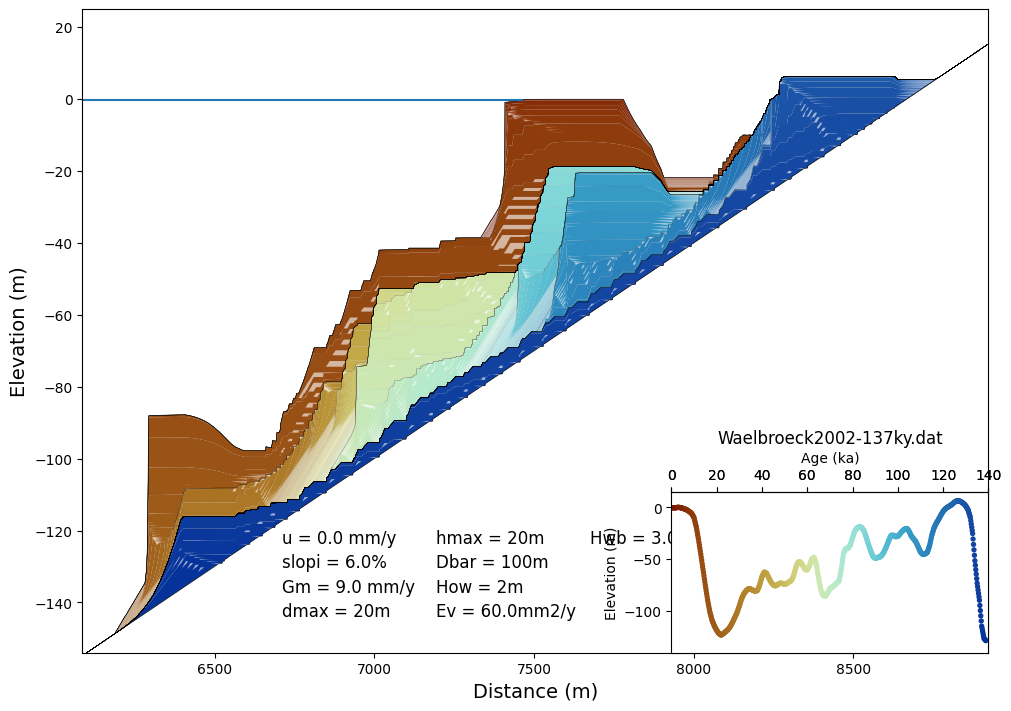

In [3]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = 0e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

## Subsidence

Simu of 139.0 ky
t 0.0


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


t 100.0
Duration 0:00:19.919576
Starting plot


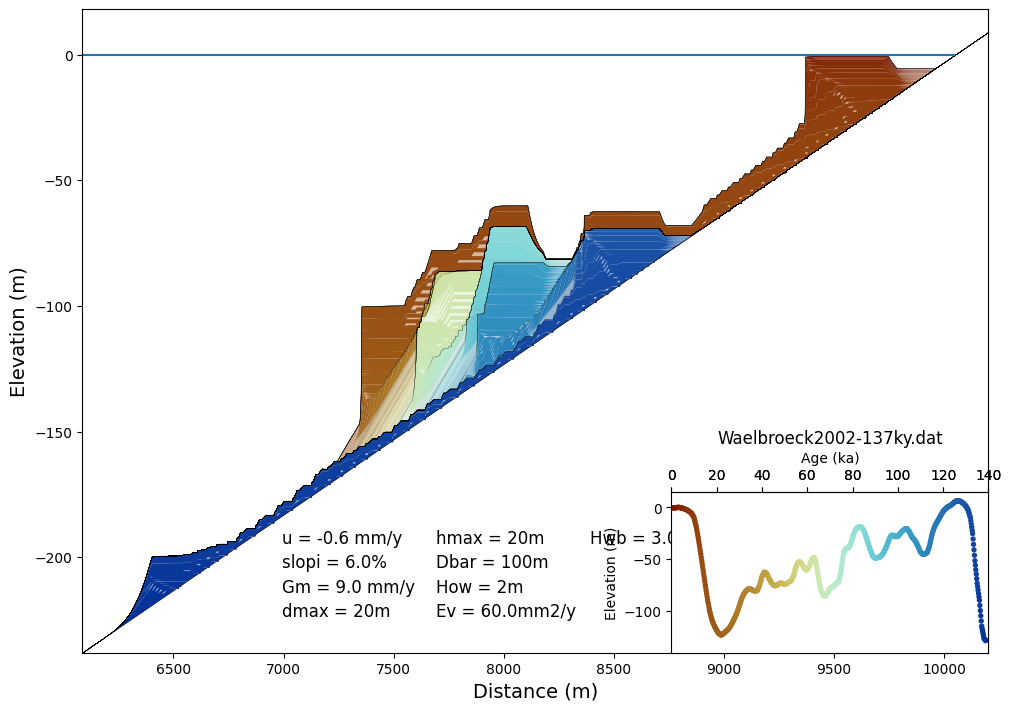

In [4]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = -0.6e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

## Uplift

Simu of 139.0 ky
t 0.0


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


t 100.0
Duration 0:00:19.667098
Starting plot


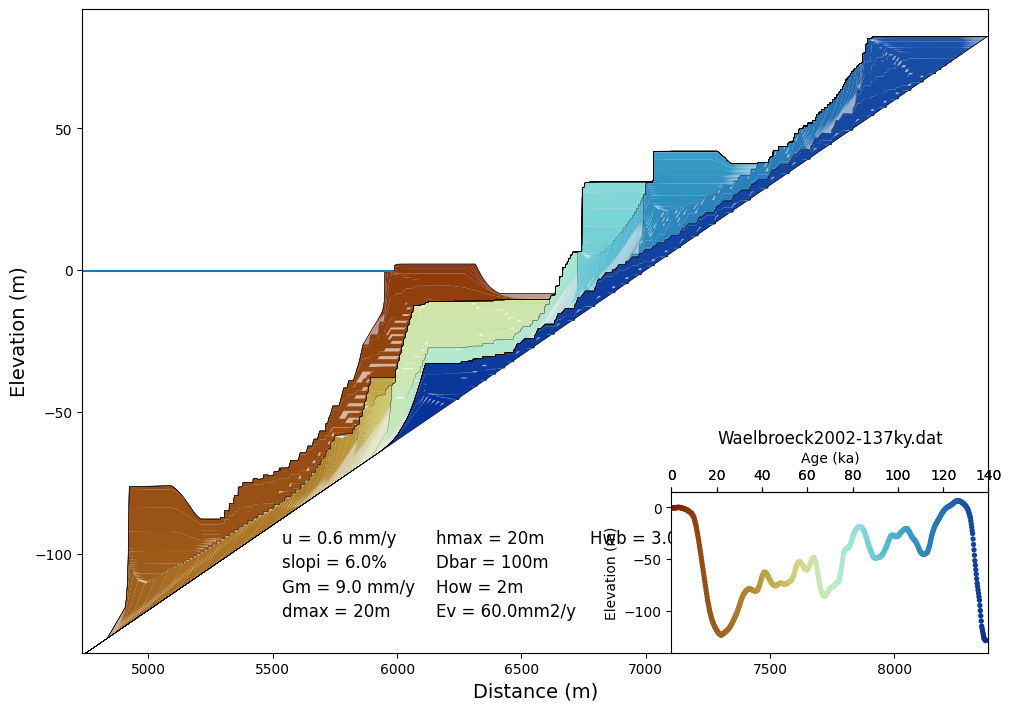

In [5]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = 0.6e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

# Reconstructing an existing geomorphology

Here, the job is to reconstruct the following topographic profile :

<img src="../Images/Sumba_view.png" alt="title" width="550"> <img src="../Images/Topo_Cape.png" alt="title" width="500">

This is Sumba island, in Indonesia. A benchmark for long coral records, as the oldest ones were dated at 1 Ma.

### Some questions :

 - From the profile, is it possible to approximate the eroded flux? The reef growth rate?
 - What is the local vertical movement (uplift/subsidence)?
 - Can you extract an approximation of the initial slope of the substrate from the profile?
 - Given the following sea-level curve, can you give an approximation of the vertical movement? Hint : the highest topography (~500 m) is dated at 1 Ma.



<img src="../Images/SL_Bintanja.png" alt="title" width="800">



#### From your deductions, test some values in the reef_params function.
 - U : vertical movement (positive is uplift, negative is subsidence)
 - slop : the initial slope of the substrate
 - Gm : Reef growth rate 
 - Ev : eroded flux
   
Everything in meter and year.

You can try with : <br>
Gm between 3e-3 and 10e-3 <br>
Ev between 50e-3 and 100e-3

Simu of 1001.0 ky
t 0.0


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


t 100.0
t 200.0
t 300.0
t 400.0
t 500.0
t 600.0
t 700.0
t 800.0
t 900.0
t 1000.0
Duration 0:00:16.493356


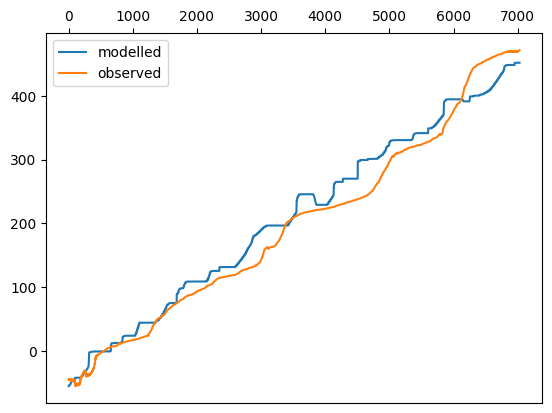

In [6]:
# Set the variables
REEF.reef_params(SL = 'Bintanja2005.dat',
                U = ,
                slop = ,
                Gm = ,
                Ev = )

# Run the model
ds_out = REEF.run(dt = 400, save = False)

# Plot the output
REEF.plot(compare='Laundi_dGPS_Denovan.dat')